# Max Q

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This prints the output of all variables, not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This makes plots with higher resolutions
%config InlineBackend.figure_format ='retina'
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
#from dataclasses import dataclass

# TODO This should be a dataclass
class State:
    """ State should be Immutable.
        States with the same variables and same values are equal and have the same hash.
    """
    def __init__(self, variables):
        ''' variables should be a dict
        '''
        for var, value in variables.items():
            setattr(self, var, value)

    def get(self):
        return dict(self.__dict__.items())

    def __str__(self):
        s = 'State('
        for key, value in self.get().items():
            s += str(key) + '=' + str(value) + ', '
        s = s[:-2] + ')'
        return s

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.get() == other.get()

    def __ne__(self, other):
        return not(self == other)
    
    def __add__(self, other):
        return State({**self.get(), **other.get()})

    def __hash__(self):
        variables = tuple([i for var in self.get().items() for i in var])
        return hash(variables)

State({'x': 5, 'y': 6})

State(x=5, y=6)

In [3]:
light_grey = [0.8,0.8,0.8]
darker_grey = [0.6,0.6,0.6]
yellow = [1.0,1.0,0.0]
blue = [0.4,0.8,1.0]
green = [0.2,1.0,0.4]

In [4]:
class GridEnv:
    
    def __init__(self, height=10, width=10):        
        self.width, self.height = width, height

    def render(self, task=None, ax=None):
        if ax is None:
            ax = plt.gca()

        ax.clear()
        ax.title.set_text('Grid Env')

        # Plot the grid
        grid = [[ light_grey for i in range(self.width)] for j in range(self.height)]
        im = ax.imshow(grid)
        
        # Plot Connections
        #ax.plot([0, 1], [0, 2], color=darker_grey)

        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        w, h = len(grid[0]), len(grid)
        ax.set_xticks(range(w))
        ax.set_yticks(range(h))
        ax.set_xticklabels(range(w))
        ax.set_yticklabels(range(h))
        ax.set_xticks(np.arange(w+1)-.5, minor=True)
        ax.set_yticks(np.arange(h+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)
        
        if task:
            task.render(ax=ax)

env = GridEnv(8, 8)

In [5]:
class NavigationTask:
    
    def __init__(self, env, goal_pos=(1,2)):
        self.env = env
        self.goal_pos = goal_pos

        self.actions = dict(enumerate(['South', 'North', 'East', 'West']))

        self.state_variables = ['agent_pos', 'goal_pos']
        
        self.title = 'Navigation Task'

        self.reset()
    
    def reset(self):
        self.agent_pos = [np.random.randint(0, self.env.width), np.random.randint(0, self.env.height)]
        return self.state
        
    @property
    def state(self):
        """ All variables must be hashable --> tuple, not list """
        return State({'agent_pos': tuple(self.agent_pos), 'goal_pos': tuple(self.goal_pos)})
    
    def step(self, action):
        """ South, North, East, West """
        reward = -1
        done = False
        
        # South
        if action == 0:            
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.height - 1)
        
        # North
        elif action == 1:
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        
        # East
        elif action == 2:
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.width - 1)
        
        # West
        elif action == 3:
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)

        if tuple(self.agent_pos) == self.goal_pos:
            reward = 0
            done = True

        # state, reward, done, info
        return self.state, reward, done

    def render(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        ax.title.set_text(self.title)
        ax.add_patch(plt.Circle(xy=self.agent_pos, radius=0.4, color=yellow))
        ax.text(self.goal_pos[0], self.goal_pos[1], 'G', fontsize=16, horizontalalignment='center', verticalalignment='center')

        
nav_task = NavigationTask(env, goal_pos=(2,1))

Actions	 {0: 'South', 1: 'North', 2: 'East', 3: 'West'}
State	 State(goal_pos=(2, 1), agent_pos=(2, 2))


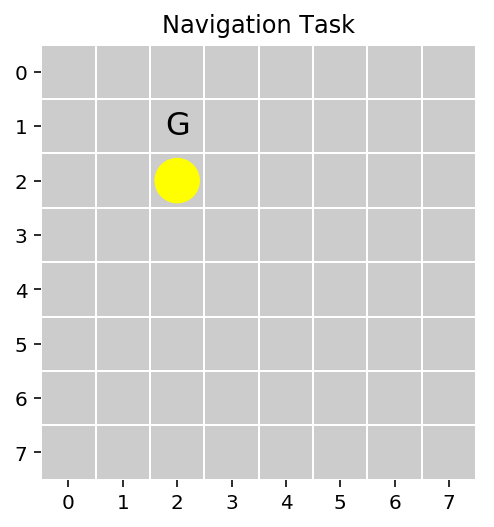

In [6]:
print('Actions\t', nav_task.actions)
print('State\t', nav_task.state)

env.render(nav_task)

In [11]:
class TaxiTask:
    
    def __init__(self, env, landmarks=[[1,1], [7,0], [2,5], [5,7]]):
        self.env = env
        self.landmarks = landmarks
        
        self.actions = dict(enumerate(['South', 'North', 'East', 'West', 'Pickup', 'Dropoff']))
        
        self.state_variables = ['passenger_pos_idx', 'passenger_goal_idx']
        
        self.title = 'Taxi World'
        
        self.reset()
        
    def reset(self):
        self.passenger_in_taxi = False
        choices = np.random.choice(len(self.landmarks), size=2, replace=False)

        self.passenger_pos = self.landmarks[choices[0]]
        self.passenger_goal_pos = self.landmarks[choices[1]]
        self.taxi_pos = [np.random.randint(0, self.env.width), np.random.randint(0, self.env.height)]

        return self.state
        
    @property
    def state(self):
        if self.passenger_in_taxi:
            passenger_pos_idx = len(self.landmarks)
        else:
            passenger_pos_idx = self.landmarks.index(self.passenger_pos)
            
        goal_idx = self.landmarks.index(self.passenger_goal_pos)

        return State({'agent_pos': self.taxi_pos, 'passenger_pos_idx': passenger_pos_idx, 'passenger_goal_idx': goal_idx})

    def step(self, action):
        reward = -1
        done = False
        
        # South
        if action == 0:
            self.taxi_pos[1] = min(self.taxi_pos[1] + 1, self.env.height - 1)
        
        # North
        elif action == 1:
            self.taxi_pos[1] = max(self.taxi_pos[1] - 1, 0)
        
        # East
        elif action == 2:
            self.taxi_pos[0] = min(self.taxi_pos[0] + 1, self.env.width - 1)
        
        # West
        elif action == 3:
            self.taxi_pos[0] = max(self.taxi_pos[0] - 1, 0)
        
        # Pickup
        elif action == 4:
            if self.taxi_pos == self.passenger_pos and not self.passenger_in_taxi:
                self.passenger_in_taxi = True
            else:
                reward = -10
        
        # Dropoff
        elif action == 5:
            if self.passenger_in_taxi and self.passenger_pos == self.passenger_goal_pos:
                self.passenger_in_taxi = False
                reward = 50
                done = True
            elif self.passenger_in_taxi and self.passenger_pos in self.landmarks:
                self.passenger_in_taxi = False
            else:
                reward = -10
        
        if self.passenger_in_taxi:
            self.passenger_pos = self.taxi_pos.copy()
            
        return self.state, reward, done
    
    def render(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        ax.title.set_text(self.title)
        for landmark in self.landmarks:
            ax.add_patch(plt.Circle(xy=landmark, radius=0.4, color=darker_grey))
        ax.add_patch(plt.Circle(xy=self.taxi_pos, radius=0.4, color=yellow))
        ax.add_patch(plt.Circle(xy=self.passenger_pos, radius=0.25, color=blue))
        ax.text(self.passenger_goal_pos[0], self.passenger_goal_pos[1], 'G',
                fontsize=16, horizontalalignment='center', verticalalignment='center')

Actions	 {0: 'South', 1: 'North', 2: 'East', 3: 'West', 4: 'Pickup', 5: 'Dropoff'}
State	 State(passenger_pos_idx=3, passenger_goal_idx=1, agent_pos=[5, 3])


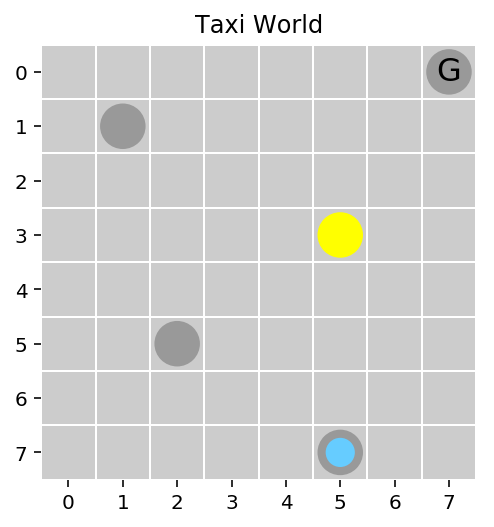

In [13]:
taxi_task = TaxiTask(env)

print('Actions\t', taxi_task.actions)
print('State\t', taxi_task.state)

env.render(taxi_task)

In [14]:
s1 = nav_task.reset()
s1
s2 = taxi_task.reset()
s2

State(goal_pos=(2, 1), agent_pos=(7, 6))

State(passenger_pos_idx=1, passenger_goal_idx=2, agent_pos=[0, 7])